# Traffic Sign Classification Project

In this project, we will use a Convolutional Neural Network (CNN) to build, train, and test a traffic sign classification model. We will use TensorFlow and Keras to construct and evaluate the model. This is a multiclass classification problem where the model aims to classify images of traffic signs into one of several predefined classes. This model can be used to enhance the functionality of smart cars.

Note this code assumes the following structuretraffic_classifier
```
├── traffic_classifier.ipynb
└── data
    ├── test
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    └── train
        ├── 1
        │   ├── image1.jpg
        │   ├── image2.jpg
        │   └── ...
        ├── 2
        │   ├── image1.jpg
        │   ├── image2.jpg
        │   └── ...
        └── ...

```
the data for this project from https://www.kaggle.com/code/saliharanauzun/cnn-gtsrb-german-traffic-sign

### Table of Contents
1. Prepare the Data
2. Build the Model
3. Train the Model
4. Evaluate the Model

## Prepare the Data
First, let's import the necessary libraries and define a function to compute the mean dimensions of the training images.



In [10]:
# Importing libraries
import os
import random
from typing import Union, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

Define Function to Compute Mean Image Dimensions

In [11]:
def get_images_mean_dimensions(folder_path: Union[str, os.PathLike]) -> Tuple[int, int]:
    """
    Compute the mean dimensions (width and height) of all images in the given folder.

    Args:
    - folder_path (str or os.PathLike): Path to the folder containing image subfolders.

    Returns:
    - Tuple[int, int]: Mean width and height of the images.
    """
    total_width = 0
    total_height = 0
    num_images = 0

    # Initialize tqdm progress bar
    pbar = tqdm(os.listdir(folder_path), desc="Processing Classes", unit="class")

    for class_folder in pbar:
        class_folder_path = os.path.join(folder_path, class_folder)

        if os.path.isdir(class_folder_path):
            pbar_images = tqdm(os.listdir(class_folder_path), desc=f"Processing Images in {class_folder}", unit="image")

            for filename in pbar_images:
                file_path = os.path.join(class_folder_path, filename)

                if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                    with Image.open(file_path) as img:
                        width, height = img.size
                        total_width += width
                        total_height += height
                        num_images += 1

    if num_images > 0:
        mean_width = int(total_width / num_images)
        mean_height = int(total_height / num_images)
        return mean_width, mean_height
    else:
        return 0, 0  # No images found, return (0, 0)


Define Function to Resize Images

In [12]:
def resize_images(main_folder_path: Union[str, os.PathLike], img_width: int, img_height: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Resize images in subfolders of the specified main folder and convert them to numpy arrays.

    Args:
    - main_folder_path (str or os.PathLike): Path to the main folder containing subfolders.
    - img_width (int): Target width for resizing.
    - img_height (int): Target height for resizing.

    Returns:
    - tuple: Tuple containing resized images (as numpy arrays) and their corresponding class labels.
    """
    images = []
    label_ids = []

    for class_folder_name in tqdm(os.listdir(main_folder_path), desc="Processing Classes", unit="class"):
        class_folder_path = os.path.join(main_folder_path, class_folder_name)

        if os.path.isdir(class_folder_path):
            pbar_images = tqdm(os.listdir(class_folder_path), desc=f"Processing Images in {class_folder_name}", unit="image")

            for filename in pbar_images:
                file_path = os.path.join(class_folder_path, filename)

                if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                    with Image.open(file_path) as img:
                        img_resized = img.resize((img_width, img_height))
                        img_array = np.array(img_resized)

                    images.append(img_array)
                    class_folder_name = int(class_folder_name)
                    label_ids.append(class_folder_name)

    return np.array(images), np.array(label_ids)

Plotting Random Images

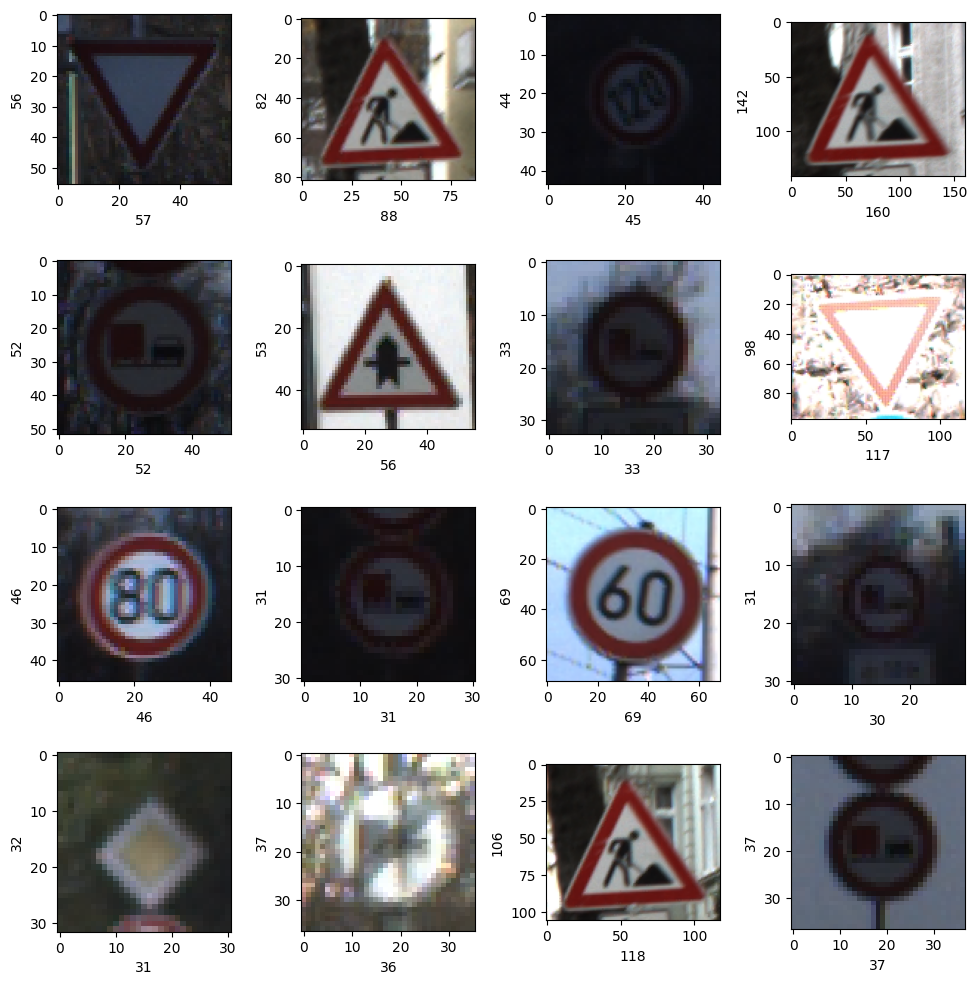

In [13]:
plt.figure(figsize=(10, 10))
path = "data/Test"
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize=10)
    plt.ylabel(rand_img.shape[0], fontsize=10)
plt.show()

Compute and Print Mean Dimensions

In [14]:
images_path = "data/Train"
w_mean, h_mean = get_images_mean_dimensions(images_path)
print("Mean Dimension (Width, Height):", (w_mean, h_mean))

Processing Classes: 100%|██████████| 43/43 [04:34<00:00,  6.38s/class]

Mean Dimension (Width, Height): (50, 50)


Resize Images to Mean Dimensions

In [15]:
images, label_ids = resize_images(images_path, w_mean, h_mean)

Processing Classes: 100%|██████████| 43/43 [00:35<00:00,  1.23class/s]


Normalize Images

In [16]:
images = images / 255.0

Check Data Shapes

In [17]:
print("Number of images:", len(images))
print("Shape of an image:", images[0].shape)
print("Number of labels:", len(label_ids))

Number of images: 39209
Shape of an image: (50, 50, 3)
Number of labels: 39209


Convert Labels to Categorical

In [18]:
label_ids = np.array(label_ids)
label_ids.shape

# Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, label_ids, test_size=0.2, random_state=42)

# One-hot encoding the labels
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
x_train.shape[1:]

(50, 50, 3)

## Build the Model

Define and Compile the Model

### <span style="color:blue">pytorch approach (not the main workflow for this workflow), you can skip</span>

In [129]:
# Storing all lables
all_labels = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

In [96]:
# note that in pytorch test folder should contain the classes as subfolder so that the dataloader work well.

# Import libraries
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

model=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Dropout(0.5),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Dropout(0.5),
                    nn.Flatten(),
                    nn.Linear(64*11*11,128),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(128,43),
#                    nn.Softmax(dim=1) In PyTorch, CrossEntropyLoss expects raw logits because it applies Softmax internally for numerical stability reasons.
                    #Adding an extra Softmax in the model would cause redundancy and numerical instability,
                    #leading to poor model performance.
                    )

In [97]:
# Define transformations for training and testing sets
transform=transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

# Load the training and test datasets
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# test_dataset = datasets.ImageFolder(root='data/test', transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

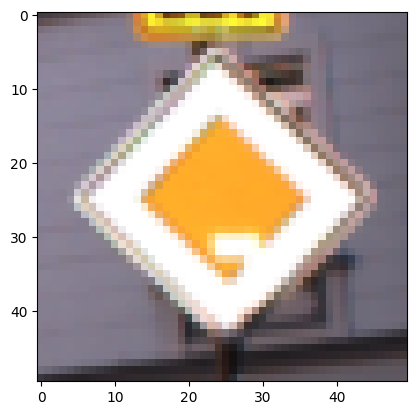

Label: 12


In [89]:
from torchvision import transforms, datasets, utils


# Function to reverse the normalization and display the image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to (H, W, C) format
    plt.show()  # Display the image

# Get one batch of images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select the first image and label from the batch
image = images[0]
label = labels[0]

# Show the image
imshow(image)

# Print the label
print('Label:', train_dataset.classes[label])

In [141]:
# 3. Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Train the model
def train(model, train_loader,criterion,optimizer, num_epochs=10 ):
    model.train()
    for epoch in range(num_epochs):
        running_loss=0
        for images, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss =criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print (f"Epoch [{epoch + 1}/ {num_epochs}], loss : {running_loss/len(train_loader)}")


In [100]:
train(model, train_loader, criterion, optimizer, num_epochs=10)

torch.save(model.state_dict(), 'model.pth')

Epoch [1/ 10], loss : 1.528514980880899
Epoch [2/ 10], loss : 0.656341693323063
Epoch [3/ 10], loss : 0.4960758968956805
Epoch [4/ 10], loss : 0.4215453323858014
Epoch [5/ 10], loss : 0.37241484987781936
Epoch [6/ 10], loss : 0.3432655998761652
Epoch [7/ 10], loss : 0.31961222708705345
Epoch [8/ 10], loss : 0.2985225622564992
Epoch [9/ 10], loss : 0.28197641722055766
Epoch [10/ 10], loss : 0.27819710004570336


Predicted class: Speed limit (120km/h)


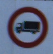

In [140]:
# predict results

model.load_state_dict(torch.load('model.pth'))
model.eval

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image
from PIL import Image


image_path = r'E:\Github\traffic sign classification\data\Test\00000.png'
input_image = preprocess_image(image_path)
with torch.no_grad():
    output = model(input_image)
    _, predicted = torch.max(output.data, 1)

print(f'Predicted class: {all_labels[predicted.item()]}')
img = Image.open(image_path)
img


### <span style="color:blue">tensorflow approach</span>.

In [58]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=x_train.shape[1:], activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

f:\Khalid\Documents\miniconda3\envs\traffic_sign_classifier\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,035,627 (3.95 MB)

 Trainable params: 1,035,627 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Fit the Model

In [60]:
model.fit(x_train, y_train_cat, epochs=10, batch_size=128, validation_data=(x_val, y_val_cat), verbose=2)

Epoch 1/10
246/246 - 124s - 503ms/step - accuracy: 0.2901 - loss: 2.6093 - val_accuracy: 0.6423 - val_loss: 1.4026
Epoch 2/10
246/246 - 60s - 245ms/step - accuracy: 0.6017 - loss: 1.2649 - val_accuracy: 0.8856 - val_loss: 0.5180
Epoch 3/10
246/246 - 59s - 239ms/step - accuracy: 0.7453 - loss: 0.7990 - val_accuracy: 0.9475 - val_loss: 0.2952
Epoch 4/10
246/246 - 70s - 283ms/step - accuracy: 0.7982 - loss: 0.6179 - val_accuracy: 0.9592 - val_loss: 0.2213
Epoch 5/10
246/246 - 64s - 262ms/step - accuracy: 0.8288 - loss: 0.5277 - val_accuracy: 0.9707 - val_loss: 0.1440
Epoch 6/10
246/246 - 79s - 322ms/step - accuracy: 0.8516 - loss: 0.4553 - val_accuracy: 0.9751 - val_loss: 0.1352
Epoch 7/10
246/246 - 73s - 299ms/step - accuracy: 0.8628 - loss: 0.4154 - val_accuracy: 0.9753 - val_loss: 0.1036
Epoch 8/10
246/246 - 61s - 247ms/step - accuracy: 0.8761 - loss: 0.3776 - val_accuracy: 0.9793 - val_loss: 0.0985
Epoch 9/10
246/246 - 63s - 255ms/step - accuracy: 0.8865 - loss: 0.3503 - val_accuracy:

Plot Training History

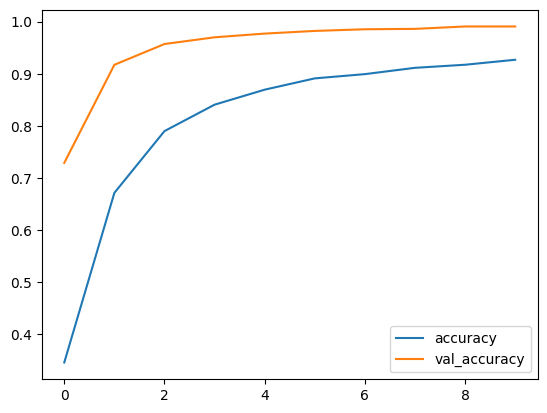

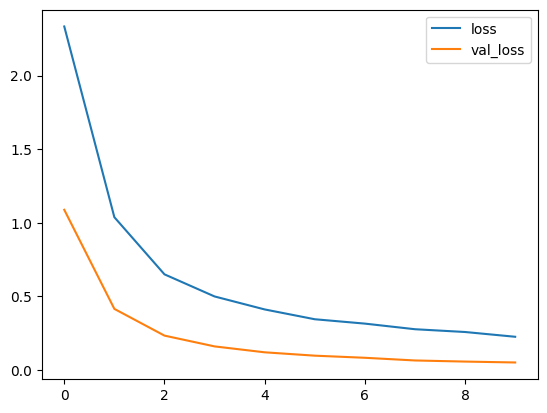

In [13]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()
plt.show()

Save the Model

In [61]:
model.save("traffic_sign_classifier.keras")

## Evaluate the Model

Load the Model and Evaluate on Test Data

In [15]:
from keras.models import load_model
traffic_sign_classifier = load_model("traffic_sign_classifier.keras")

crreate list ot dictionary for each class id

In [61]:
# Storing all lables
all_labels = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

Define Function for Scaling Test Images (process before prediction)

In [16]:
def scaling(test_images: list, test_path: str) -> np.ndarray:
    """
    Scale test images to the required dimensions.

    Args:
    - test_images (list): List of test image filenames.
    - test_path (str): Path to the folder containing test images.

    Returns:
    - np.ndarray: Array of scaled test images.
    """
    images = []

    for x in test_images:
        img = Image.open(os.path.join(test_path, x))
        img = img.resize((50, 50))
        img = np.array(img)
        images.append(img)

    images = np.array(images)
    images = images / 255.0

    return images

choose folder of images (test_path) and the images to select in that path (test_images_files)

In [86]:
test_path = 'data/Test'
# for all images in path
# test_images_files = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]
test_images_files= ['00000.png','00001.png','00002.png','00003.png','00004.png'] # for specific images
test_images = scaling(sorted(test_images_files), test_path)

do the prediction (note each item in the prediction is one hot encoding values so the maximum value is the predicted class)

In [101]:
predicted_classes=traffic_sign_classifier.predict(test_images)
len(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


5

In [117]:
# the output is a list of 43 item (number of classes)
predicted_classes[0]

array([9.7044219e-19, 2.4233768e-17, 1.3473114e-16, 1.9629388e-08,
       1.4432677e-11, 2.1142336e-07, 1.1551800e-17, 2.7515304e-07,
       1.3873460e-09, 2.7173733e-06, 1.6858509e-08, 1.6844567e-15,
       1.8083040e-14, 7.3458488e-19, 1.7743589e-19, 1.0998587e-14,
       9.9999678e-01, 7.2770292e-23, 1.7098648e-18, 3.4399625e-12,
       1.0027673e-13, 3.5037472e-18, 7.7218464e-29, 2.5186361e-16,
       4.4786982e-24, 4.5885580e-19, 1.3121897e-18, 7.5465609e-23,
       1.5108042e-19, 1.7622406e-23, 6.5058283e-19, 1.1213047e-19,
       3.4123057e-13, 1.2953261e-16, 5.8800432e-17, 1.4324997e-16,
       1.9946085e-18, 1.2714125e-22, 9.0280988e-21, 3.1506649e-24,
       1.4944172e-18, 1.5196507e-15, 5.7531575e-15], dtype=float32)

find the class labels

In [122]:
# Convert to a regular 2D array
arr_2d = np.stack(predicted_classes)

# Find maximum elements along the second axis (rows)
predicted_class_ids = np.argmax(arr_2d, axis=1)
predicted_class_labels = [all_labels[i] for i in predicted_class_ids]

result_list=list(zip(test_images_files, predicted_class_labels))
result_list

[('00000.png', 'Vechiles over 3.5 metric tons prohibited'),
 ('00001.png', 'Speed limit (30km/h)'),
 ('00002.png', 'Keep right'),
 ('00003.png', 'Turn right ahead'),
 ('00004.png', 'Right-of-way at the next intersection')]